# Policy Gradient

Policy gradient method for reinforcement learning learns the policy directly, not the Q-function. Compared to Q-learning it is more straightforward to use with continuous state and action spaces.

## Formula

In reinforcement learning we are trying to find a policy that maximizes the sum of rewards over episode.

$$
R = r_1 + r_2 + ... + r_n
$$

$$
\pi^* = argmax_{\pi} E[R]
$$

While the expectation depends both on environment transitions $P(s_{t+1}|s_t, a_t)$ and actions chosen by the policy $\pi_{\theta}(a_t|s_t)$, we only have control over the latter. Therefore we want to change the policy parameters $\theta$ in a way that would maximize the expectation (average value) of $R$. We can do this by taking gradient steps with respect to the $\theta$. Turns out these gradients can be estimated with following formula (for details see [these slides](http://rail.eecs.berkeley.edu/deeprlcourse/static/slides/lec-5.pdf)):

$$
\nabla_{\theta} E[R] = E\left[\sum_{t=0}^n \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) (R_t - b) \right]
$$

Here $b$ represents the **baseline** or average return. Commonly used baseline is state value $V(s_t)$, because by definition *it is* the average return. The quantity $R_t -b$ is often referred to as an **advantage**. Indeed it measures "how much better was the return this time compared to the average".

## Implementation

When looking at the policy gradient formula, it may not be evident how to implement it without digging into the depths of TensorFlow. Actually the implementation can be very simple, with a small modification to supervised learning loss function. Remember that most loss functions used in supervised learning actually try to maximize the log-likelihood of the target value:

* categorical cross-entropy loss function is $L = -\sum_i \log(p_{ik})$. By minimizing the negative log probability, it actually tries to maximize the log probability of the target class $k$ of sample $i$.
* mean squared error loss function is $L = \sum_i (\hat{y}_i-y_i)^2$. By minimizing the mean squared error, it [actually tries to](https://www.jessicayung.com/mse-as-maximum-likelihood/) maximize the log probability of $y_i$ under Gaussian distribution with mean $\hat{y}_i$ and fixed standard deviation.

For the general case we can rewrite those loss functions as 

$$
L = -\sum_i \log p_{\theta}(y_i|x_i) \alpha_i
$$

where $\theta$ represents the parameters (weights) of the network, $x_i$ is the input to the network, $y_i$ is the target output and $\alpha_i$ is a sample weight. Sample weighting is used in supervised learning to fight the class imbalance. It is already implemented in Keras as `sample_weight` parameter to `Model.fit()` method. Note that the gradient of the loss function now looks a lot like policy gradient formula:

$$
\nabla_{\theta} L = -\sum_i \nabla_{\theta} \log p_{\theta}(y_i|x_i) \alpha_i
$$

Because sample weights $\alpha_i$ are constants, they pass through the gradient operation as just multipliers. Now the only thing left is to replace supervised learning terminology with reinforcement learning terms:

$$
\begin{align}
p_{\theta}(y_i|x_i) &= \pi_{\theta}(a_t|s_t)\\
\alpha_i &= R_t - b\\
i &= t
\end{align}
$$

This gives us the policy gradient loss function, with the only difference of negative sign, because loss functions are usually minimized, not maximized:
$$
L = -\sum_{t=0}^n \log \pi_{\theta}(a_t|s_t) (R_t - b)
$$

In Keras we can use states as model input, actions as model output and advantages as sample weights.

## Intuition

While the mathematical formulation of policy gradient might be a bit involved, the intuition behind it is pretty straightforward. First note that without the advantage part, the policy gradient is just normal log-likelihood maximization, meaning it increases the probability of chosen actions. Advantages just weight whether the probability is increased or decreased and how much:

* if $R_t - b$ is positive, then current return was better than usual and the probability of the action is *increased*.
* if $R_t - b$ is negative, then current return was better than usual and the probability of the action is instead *decreased*.

For example with discrete action space when using softmax operation to calculate the probabilities, increasing the probability of an action will decrease the probability of other actions - the network becomes more certain of an action. Decreasing the probability of one action actually means increasing the probability of other actions. In other words - negative advantages say that explore more, try other actions.

<img src="images/pg.png">

## Exploration

Exploration is naturally included in policy gradient method, because each time you need to take an action, you sample it from probability distribution. The final the policy gradient algorithm goes like this:
```
repeat
  collect a trajectory by sampling actions from policy
  calculate returns per time step
  calculate advantages per time step
  train the policy network with 
    states as inputs
    actions as outputs
    advantages as sample weights
until termination
```

# CartPole Example

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
# create the CartPole environment
env = gym.make('CartPole-v0')
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(4,)
Action space: Discrete(2)


In [3]:
# create a model with two hidden layers
x = Input(shape=env.observation_space.shape)
h1 = Dense(64, activation='tanh')(x)
h2 = Dense(64, activation='tanh')(h1)
p = Dense(env.action_space.n, activation='softmax')(h2)

# use RMSProp optimizer and categorical crossentropy loss
model = Model(x, p)
model.compile(optimizer=RMSprop(0.003), loss='sparse_categorical_crossentropy')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________


In [4]:
# calculate returns
def calculate_returns(rewards, dones, discount=0.9):
    returns = []
    for reward, done in zip(reversed(rewards), reversed(dones)):
        if done:
            ret = reward
        else:
            ret = reward + discount * ret
        returns.insert(0, ret)
    return returns

# buffers to keep average returns per timestep
timestep_returns = np.zeros(env.spec.max_episode_steps)
timestep_counts = np.zeros(env.spec.max_episode_steps)

# calculate baselines
def calculate_baselines(returns):
    # use simple timestep-dependent average as baseline
    timestep_returns[:len(returns)] += returns
    timestep_counts[:len(returns)] += 1
    baselines = timestep_returns[:len(returns)] / timestep_counts[:len(returns)]
    return baselines

# calculate advantages
def calculate_advantages(returns, baselines):
    # calculate advantages
    advantages = returns - baselines
    # normalize advantages
    advantages /= np.std(advantages) + 0.000001
    return advantages

In [14]:
# reset statistics
episode_rewards = []
episode_lengths = []

# do 100 episodes
for i in range(100):
    states = []
    actions = []
    rewards = []
    dones = []
    episode_reward = 0
    episode_length = 0

    # collect a trajectory
    state = env.reset()
    done = False
    while not done:
        # predict action probabilities from state
        p = model.predict_on_batch(state[np.newaxis])
        # sample action from probabilities
        action = np.random.choice(env.action_space.n, p=p[0])

        # log state and action
        states.append(state)
        actions.append(action)

        # step environment
        state, reward, done, info = env.step(action)
        #env.render()

        # log reward and done
        rewards.append(reward)
        dones.append(done)

        # sum rewards per episode
        episode_reward += reward
        episode_length += 1

    # record reward statistics
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)

    print("Episode ", i + 1, "Episode reward:", episode_reward, "Episode length:", episode_length)

    # calculate returns
    returns = calculate_returns(rewards, dones)
    
    # calculate baselines
    baselines = calculate_baselines(returns)
    
    # calculate advantages
    advantages = calculate_advantages(returns, baselines)
    
    # train the network, skip training if all advantages are zeros
    if np.any(advantages):
        model.train_on_batch(np.array(states), np.array(actions), sample_weight=advantages)

Episode  1 Episode reward: 145.0 Episode length: 145
Episode  2 Episode reward: 135.0 Episode length: 135
Episode  3 Episode reward: 132.0 Episode length: 132
Episode  4 Episode reward: 132.0 Episode length: 132
Episode  5 Episode reward: 136.0 Episode length: 136
Episode  6 Episode reward: 149.0 Episode length: 149
Episode  7 Episode reward: 175.0 Episode length: 175
Episode  8 Episode reward: 172.0 Episode length: 172
Episode  9 Episode reward: 200.0 Episode length: 200
Episode  10 Episode reward: 200.0 Episode length: 200
Episode  11 Episode reward: 199.0 Episode length: 199
Episode  12 Episode reward: 174.0 Episode length: 174
Episode  13 Episode reward: 171.0 Episode length: 171
Episode  14 Episode reward: 137.0 Episode length: 137
Episode  15 Episode reward: 102.0 Episode length: 102
Episode  16 Episode reward: 173.0 Episode length: 173
Episode  17 Episode reward: 171.0 Episode length: 171
Episode  18 Episode reward: 148.0 Episode length: 148
Episode  19 Episode reward: 143.0 Epi

Text(0.5,1,'Episode lengths')

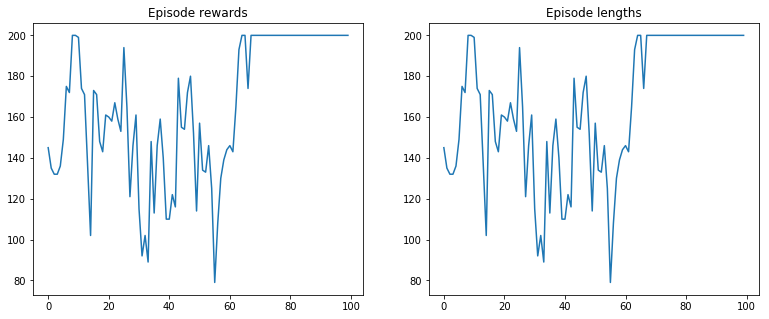

In [15]:
# plot episode rewards and lengths
# because in this environment you get reward 1 for each timestep you are alive, 
# then episode reward matches with episode length
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title("Episode rewards")
plt.subplot(1, 2, 2)
plt.plot(episode_lengths)
plt.title("Episode lengths")

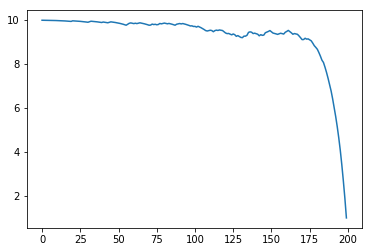

In [16]:
# plot average timestep returns. remember that these are discounted!
plt.plot(timestep_returns / timestep_counts)

In [17]:
# visualize one episode
state = env.reset()
done = False
env.render()
while not done:
    p = model.predict(state[np.newaxis])
    action = np.argmax(p[0])
    
    state, reward, done, info = env.step(action)
    env.render()
env.close()

## Final words

If you have access to environment dynamics function $P(s'|s,a)$ and reward function $R(s, a, s')$ and both are differentiable, you could theoretically optimize $E[R]$ explicitly. In practice there are some instability issues, for details see [these slides](http://rail.eecs.berkeley.edu/deeprlcourse/static/slides/lec-13.pdf) or [this paper](https://arxiv.org/abs/1510.09142). Still, it is a good idea to make use of environment model, whenever it is available (or learnable).